In [2]:
import os,sys,shutil
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import easyocr
# from paddleocr import PaddleOCR, draw_ocr

In [3]:
# Specify language to identify from images
reader = easyocr.Reader(['en','nl'], gpu = False)

Using CPU. Note: This module is much faster with a GPU.


In [4]:
# Load images
images = [cv2.imread(file) for file in glob.glob("Data/StreetSwipe/images_classified/*/*.jpg")]
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images] # correct the color channel
print(f"Total number of images: {len(images)}")

Total number of images: 2441


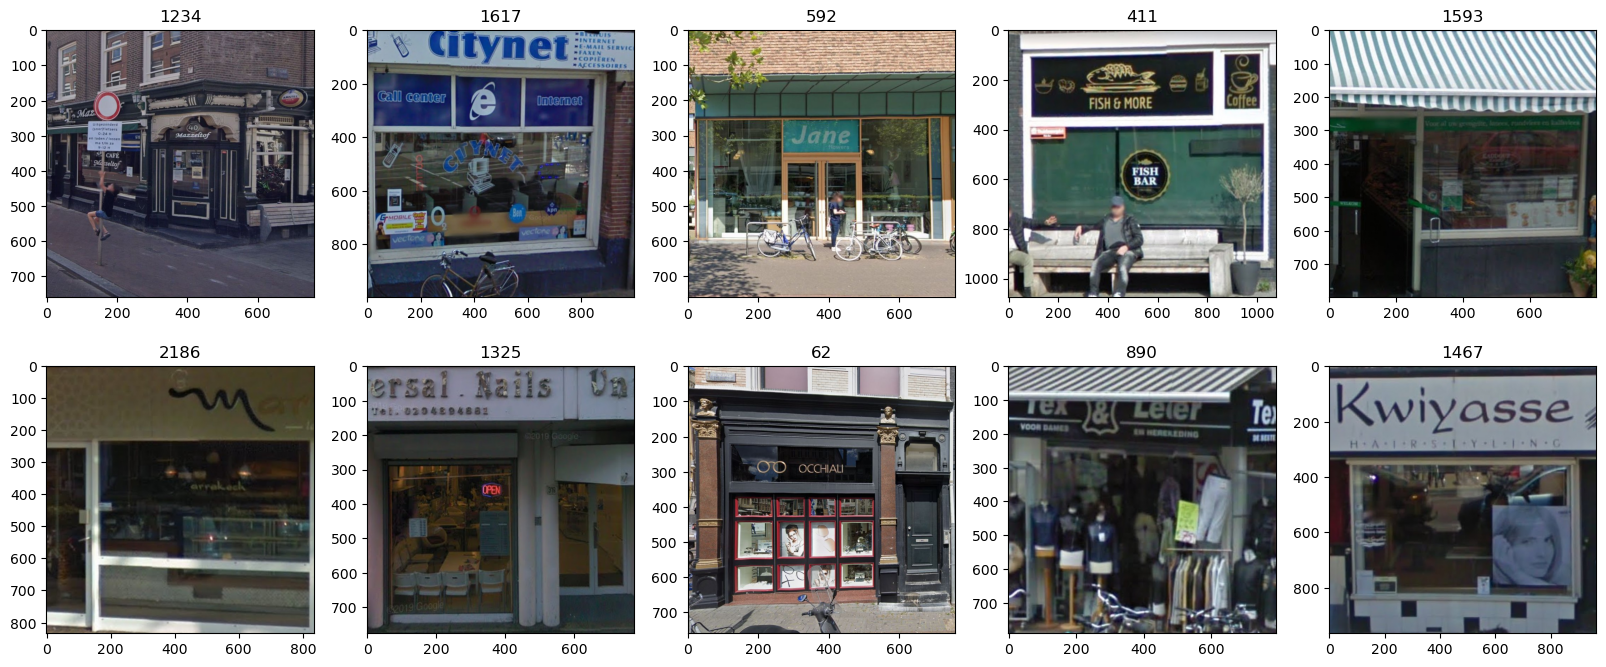

In [358]:
# Sample image
subset = np.random.randint(2441, size=(10))
test_imgs = [images[i] for i in subset]

fig = plt.figure(figsize=(20,8))
rows, cols = 2, 5

for i in range(0, cols*rows):
  fig.add_subplot(rows, cols, i+1)
  plt.imshow(test_imgs[i])
  plt.title(subset[i])
plt.show()

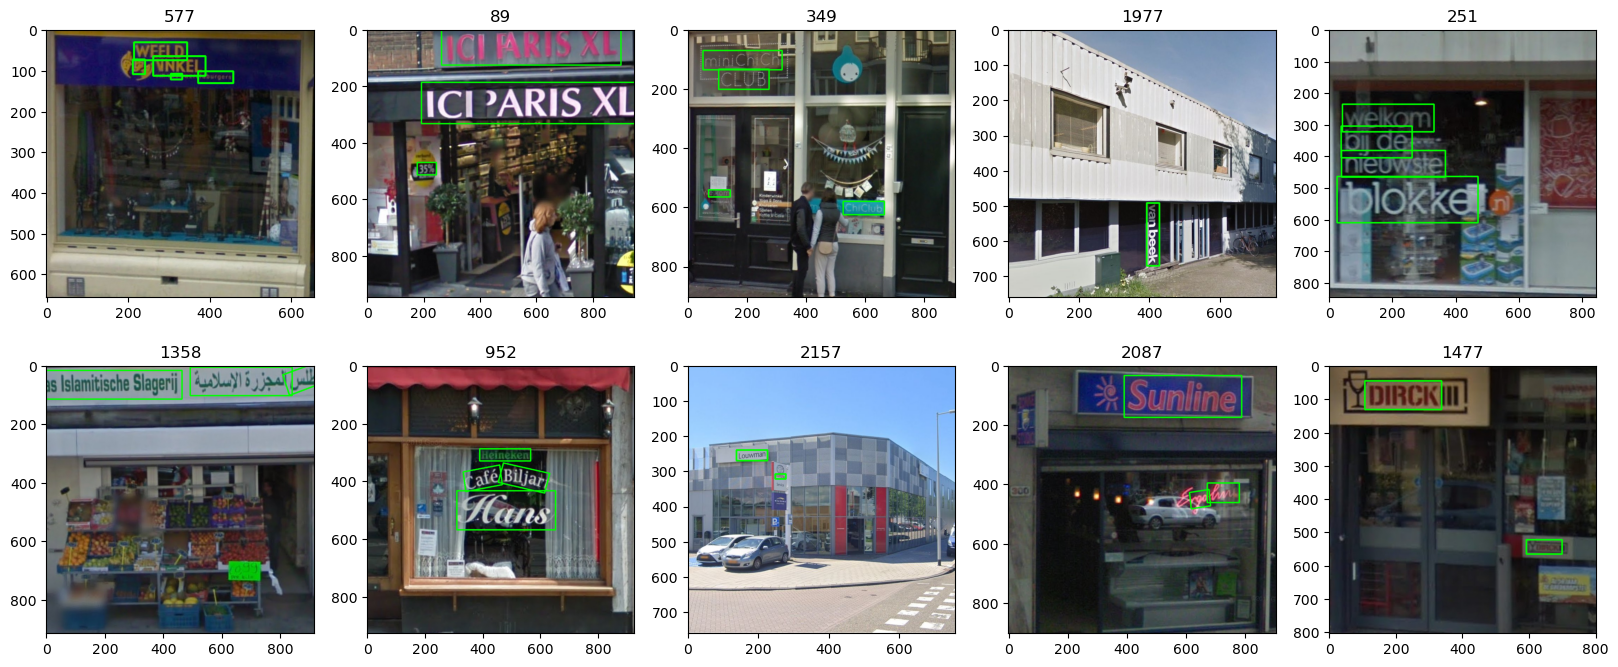

In [39]:
fig = plt.figure(figsize=(20,8))
rows, cols = 2, 5

for i in range(0, cols*rows):
    fig.add_subplot(rows, cols, i+1)

    result = reader.detect(test_imgs[i])

    result_vis = test_imgs[i]
    spacer = 100

    for box in result[0][0]: 
        top_left = (box[0], box[2])
        bottom_right = (box[1], box[3])
        result_vis = cv2.rectangle(result_vis, top_left, bottom_right, (0,255,0), 3)
        spacer+=15

    for box in result[1][0]: 
        points = np.array(box, dtype=np.int32)
        result_vis = cv2.polylines(result_vis, [points], isClosed=True, color=(0,255,0), thickness=3)
        spacer+=15

    plt.imshow(result_vis)
    plt.title(subset[i])
plt.show()

## Detect & crop

In [6]:
# make folders for cropped-out texts
# class_names = ['gentrified','non-gentrified']
# new_folder = 'Data/StreetSwipe/images_cropped'

# for name in class_names:
#     os.makedirs(os.path.join(new_folder, name))

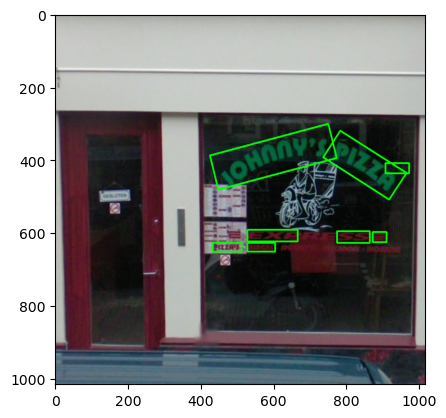

In [49]:
spacer = 100
result_vis = img

for box in result[0][0]: 
    top_left = (box[0], box[2])
    bottom_right = (box[1], box[3])
    result_vis = cv2.rectangle(result_vis, top_left, bottom_right, (0,255,0), 3)
    spacer+=15

for box in result[1][0]: 
    points = np.array(box, dtype=np.int32)
    result_vis = cv2.polylines(result_vis, [points], isClosed=True, color=(0,255,0), thickness=3)
    spacer+=15

plt.imshow(result_vis)
plt.show()

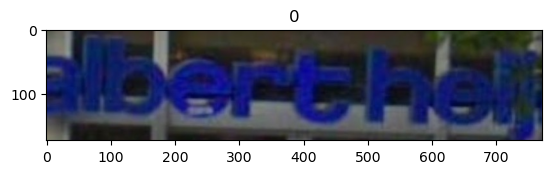

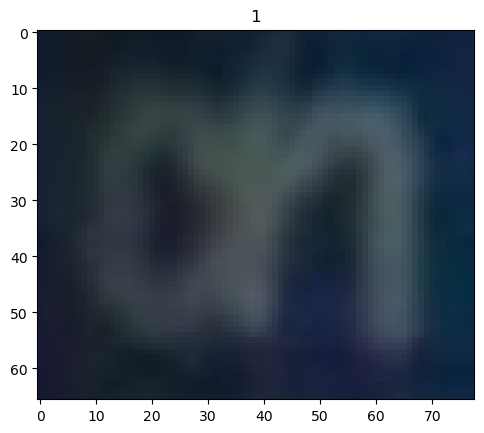

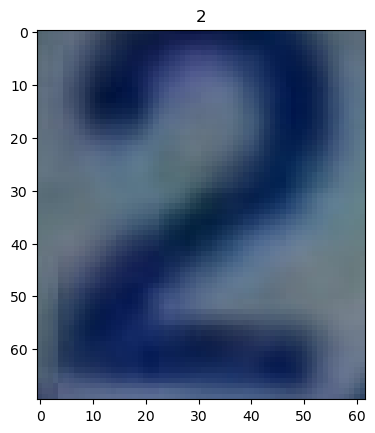

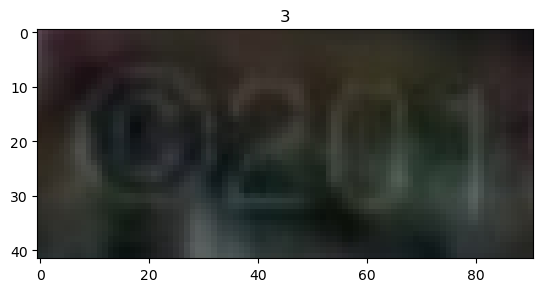

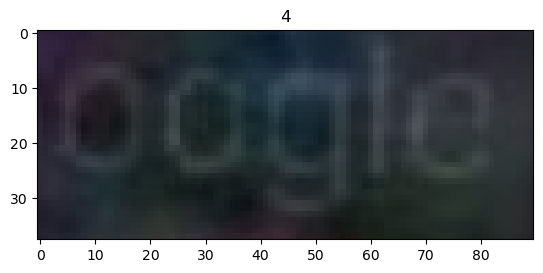

In [376]:
# empty examples: 250, 256
# rotated/non-horizontal text examples: 163, 659, 1800, 952, 1721, 1655, 912, 257, 2334
# img = images[1655]
# img = cv2.imread("Data/StreetSwipe/images_classified/gentrified/20.jpg")
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(img)
# plt.show()

result = reader.detect(img)
result
# print(len(result1[0]), len(result1[1]))
# print(bool(result1[0][0]), bool(result1[1][0]))

if not any([result[0][0], result[1][0]]):
    print("no text")
else:
    # try:
    # Crop text regions
    for i, box in enumerate(result[0][0]):
        tl = (max(0,box[0]), max(0,box[2]))
        br = (max(0,box[1]), max(0,box[3]))
        cropped_rec = img[tl[1]:br[1], tl[0]:br[0]]
    
        plt.imshow(cropped_rec)
        plt.title(i)
        plt.show()

    for i, box in enumerate(result[1][0]):
        # (1) Downside: Using min and max x and y coords, yields larger bounding boxes than the ones detected & without rotation
                # Ok most of the time, but ~30% runs into ValueError bc empty array and cannot output
        # source: https://stackoverflow.com/questions/54884289/how-do-i-crop-an-image-given-the-coordinates-of-the-four-corners-to-crop
        # x = [] ; y = []
        # for point in box:
        #     x.append(int(point[0]))
        #     y.append(int(point[1]))
        # tl_x = min(x); tl_y = min(y)
        # br_x = max(x); br_y = max(y)
        # cropped_poly = img[tl_y:br_y, tl_x:br_x]

        # (2) Downside: Output has unexpected 90º rotations for non-horizontal texts, inherently lowers accuracy of text recognition later on
                # But can handle extremely curved text (e.g. 912), doesnt run into any error
        # source: https://jdhao.github.io/2019/02/23/crop_rotated_rectangle_opencv/
        rect = cv2.minAreaRect(np.array(box, dtype=np.int32))
        bound = cv2.boxPoints(rect) ; bound = np.int0(bound) # the order of the box points: bottom left, top left, top right, bottom right
        width = int(rect[1][0]) ; height = int(rect[1][1])
        src_pts = bound.astype("float32")
        dst_pts = np.array([[0, height-1],
                            [0, 0],
                            [width-1, 0],
                            [width-1, height-1]],
                            dtype="float32")
        perspective_matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
        cropped_poly = cv2.warpPerspective(img, perspective_matrix, (width, height))
        
        plt.imshow(cropped_poly)
        plt.title(i)
        plt.show()
        
    # except ValueError:
    #     pass


In [377]:
def extract_text(origin, destination):
    """
    :origin: Folder containing images
    :destination: Folder to contain cropped-out text instances
    """
    no_text = 0
    num_file = 0
    for file in glob.glob(os.path.join(origin,'*.jpg')):
        num_file += 1
        filename = os.path.split(file)[1] # {name}.jpg
        dir = os.path.join(destination, filename)
        os.makedirs(dir) # one folder for each image

        # Read img
        img = cv2.imread(file)
        
        # Detect texts
        result = reader.detect(img, add_margin=0)

        # Crop & save text regions
        if not any([result[0][0], result[1][0]]): # if no text detected
            no_text += 1
        else:
            for i, box in enumerate(result[0][0]):
                tl = (max(0,box[0]), max(0,box[2]))
                br = (max(0,box[1]), max(0,box[3]))
                cropped_rec = img[tl[1]:br[1], tl[0]:br[0]]
                
                des_path = os.path.join(dir, f'rec{i}.jpg')
                if cropped_rec is not None:
                    cv2.imwrite(des_path, cropped_rec)
                else:
                    pass

            for i, box in enumerate(result[1][0]): 
                rect = cv2.minAreaRect(np.array(box, dtype=np.int32))
                bound = cv2.boxPoints(rect) ; bound = np.int0(bound) # the order of the box points: bottom left, top left, top right, bottom right
                width = int(rect[1][0]) ; height = int(rect[1][1])
                src_pts = bound.astype("float32")
                dst_pts = np.array([[0, height-1],
                                    [0, 0],
                                    [width-1, 0],
                                    [width-1, height-1]],
                                    dtype="float32")
                perspective_matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
                cropped_poly = cv2.warpPerspective(img, perspective_matrix, (width, height))
                
                des_path = os.path.join(dir, f'poly{i}.jpg')
                if cropped_poly is not None:
                    cv2.imwrite(des_path, cropped_poly)
                else:
                    pass
    print(f"Number of images without text: {no_text} ({100 * float(no_text)/float(num_file)}%)")

### Gentrified

In [378]:
origin_gen = 'Data/StreetSwipe/images_classified/gentrified/'
destination_gen = 'Data/StreetSwipe/images_cropped/gentrified/'
extract_text(origin_gen, destination_gen)

KeyboardInterrupt: 

### Non-gentrified

In [ ]:
origin_nongen = 'Data/StreetSwipe/images_classified/non-gentrified/'
destination_nongen = 'Data/StreetSwipe/images_cropped/non-gentrified/'
extract_text(origin_nongen, destination_nongen)